In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import scipy.stats as st
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries, load_apogee
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot, move_legend
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")

LABELS = ("MILES", "IndoUS", "MaStar")
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r""]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$"], units.values())}

In [2]:
spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=False, cache_path=CACHE_PATH, cache_label="other-libraries")

all_catalogue = pd.DataFrame()
for label, c in catalogues.items():
    c["LIBRARY"] = label
    all_catalogue = all_catalogue.append(c, ignore_index=True)

all_catalogue.rename(columns=cols, inplace=True)
all_spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

100%|##################################################| reading FITS for MILES: 973/973 [00:19<00:00, 48.70FITS/s]
100%|##################################################| extracting MILES catalogue: 973/973 [00:02<00:00, 351.77record/s]
100%|##################################################| extracting FLUX from MILES: 973/973 [00:00<00:00, 1196.95SED/s]
100%|##################################################| reading FITS for IndoUS: 1273/1273 [00:24<00:00, 51.41FITS/s]
100%|##################################################| extracting IndoUS catalogue: 1273/1273 [00:04<00:00, 261.87record/s]
100%|##################################################| extracting FLUX from IndoUS: 1273/1273 [00:01<00:00, 1174.40SED/s]
100%|##################################################| reading FITS for MaStar: 20332/20332 [10:13<00:00, 33.13FITS/s]
100%|##################################################| extracting MaStar catalogue: 20332/20332 [01:14<00:00, 272.98record/s]
100%|#################

In [3]:
import joblib

cosha = joblib.load("../busy-week/_cache/estimator-mor-v3.1.2-cleaned-v2-gsl.pk")

In [4]:
from MaStarChecks.preprocessing import fill_missing


clean_spectra = fill_missing(all_spectra)

In [5]:
y_miles = catalogues["MILES"].set_index("ID").filter(items=cols.keys()).rename(columns=cols)
y_cosha_miles = pd.DataFrame(index=y_miles.index, columns=cols.values(), data=cosha["mode"].predict(clean_spectra.loc[all_catalogue.LIBRARY=="MILES"]))
y_cosha_miles[cols["TEFF"]] = 10**y_cosha_miles[cols["TEFF"]]

y_indous = catalogues["IndoUS"].set_index("ID").filter(items=cols.keys()).rename(columns=cols)
y_cosha_indous = pd.DataFrame(index=y_indous.index, columns=cols.values(), data=cosha["mode"].predict(clean_spectra.loc[all_catalogue.LIBRARY=="IndoUS"]))
y_cosha_indous[cols["TEFF"]] = 10**y_cosha_indous[cols["TEFF"]]

y_cosha_mastar = pd.DataFrame(index=catalogues["MaStar"].index, columns=cols.values(), data=cosha["mode"].predict(clean_spectra.loc[all_catalogue.LIBRARY=="MaStar"]))
y_cosha_mastar[cols["TEFF"]] = 10**y_cosha_mastar[cols["TEFF"]]

y_miles_ext = y_miles.copy()
y_miles_ext[cols.get("ALPHAM")] = y_cosha_miles[cols.get("ALPHAM")]

y_indous_ext = y_indous.copy()
y_indous_ext[cols.get("ALPHAM")] = y_cosha_indous[cols.get("ALPHAM")]

<AxesSubplot:>

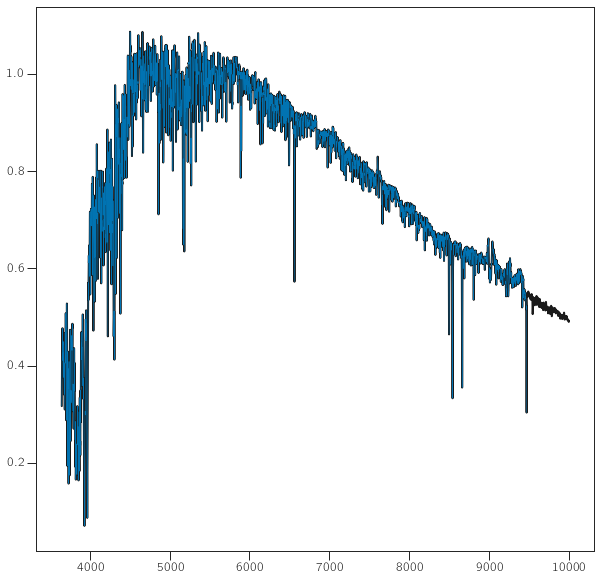

In [6]:
clean_spectra.loc[all_catalogue.LIBRARY=="IndoUS"].iloc[1].plot(use_index=True, color="k")
all_spectra.loc[all_catalogue.LIBRARY=="IndoUS"].iloc[1].plot(use_index=True, lw=0.5)

In [7]:
g = sns.PairGrid(data=y_cosha_mastar, corner=True, diag_sharey=False, height=3)

g.map_diag(sns.kdeplot, shade=True, color=MASTAR_COLOR, alpha=1.0)
g.map_lower(sns.kdeplot, levels=(0.25,0.50,0.75,1.00), bw_adjust=2, shade=True, colors=QUARTILE_PALETTE, gridsize=100, alpha=1.0)
# g.map_lower(plt.scatter, color=MASTAR_COLOR, linewidth=0, marker="o", s=7, zorder=-1)

g.data = y_miles_ext
g.map_diag(sns.kdeplot, shade=False, lw=2, color=MILES_COLOR)
g.map_lower(sns.kdeplot, bw_adjust=2, levels=(0.25,), shade=False, color=MILES_COLOR, gridsize=100)
# g.map_lower(sns.scatterplot, color=MILES_COLOR, linewidth=1, marker="+", sizes=4, alpha=1)
g.data = y_indous_ext
g.map_diag(sns.kdeplot, shade=False, lw=2, color=INDOUS_COLOR)
g.map_lower(sns.kdeplot, bw_adjust=2, levels=(0.25,), shade=False, color=INDOUS_COLOR, gridsize=100)
# g.map_lower(sns.scatterplot, color=INDOUS_COLOR, linewidth=1, marker="x", s=4)

for ax in g.axes[-1,:]:
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.LineCollection):
            plt.setp(collection, linestyle=(0, (5, 1)))

for line in g.diag_axes[-1].lines:
    if isinstance(line, matplotlib.lines.Line2D):
        plt.setp(line, linestyle=(0, (5, 1)))

g.axes[1,0].set_xscale("log")
xlim = g.axes[1,0].get_xlim()
ylim = g.axes[1,0].get_ylim()
g.axes[1,0].set_xlim(xlim[::-1])
# g.axes[1,0].xaxis.set_major_locator(plt.MaxNLocator(6))
# g.axes[1,0].xaxis.set_minor_locator(plt.MaxNLocator(3))
g.axes[1,0].set_ylim(ylim[::-1])
g.axes[1,1].set_xlim(g.axes[1,1].get_xlim()[::-1])

handles = [
    mpatches.Patch(facecolor=MASTAR_COLOR, label="MaStar"),
    mpatches.Patch(facecolor="none", edgecolor=MILES_COLOR, lw=2, label="MILES"),
    mpatches.Patch(facecolor="none", edgecolor=INDOUS_COLOR, lw=2, label="IndoUS")
]
handles_ext = [
    matplotlib.lines.Line2D([0], [0], linewidth=2, linestyle="dashed", color=MILES_COLOR, label="CoSHA(MILES)"),
    matplotlib.lines.Line2D([0], [0], linewidth=2, linestyle="dashed", color=INDOUS_COLOR, label="CoSHA(IndoUS)")
]
legend = g.axes[0,0].legend(handles=handles, loc=4)
legend_ext = g.axes[-1,0].legend(handles=handles_ext, handlelength=1.5, loc=2)

g.fig.tight_layout()
g.fig.savefig(f"_img/libraries-comparison.png", bbox_inches="tight")

In [8]:
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((2300,8000)), np.array((1.0,5.2)), np.array((-1.6,+0.6)), np.array((-0.2,+1.2))]
))
# DELTA_LIMS = dict(zip(
#     Y_COLUMNS,
#     [np.array((-300,+3000)), None, np.array([-0.9,0.5]), None]
# ))
DELTA_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((-1200,+2000)), None, np.array([-0.5,0.7]), None]
))

compare_with = "MILES"
comparison = build_comparison_table(y_cosha_miles, y_miles, labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta$")

for label, column in cols.items():
    if comparison[f"{column} {compare_with}"].isna().all(): continue
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta$",
            limx=Y_LIMS[label], limy=DELTA_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")

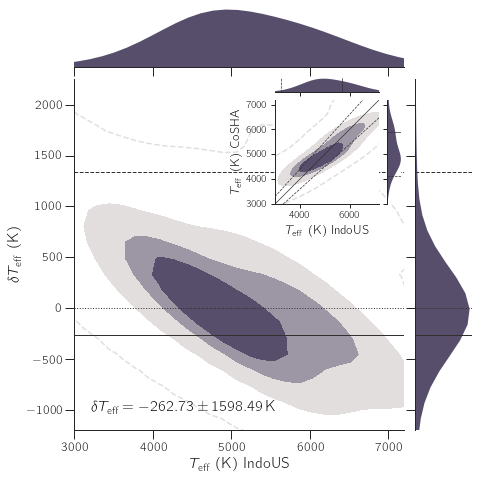

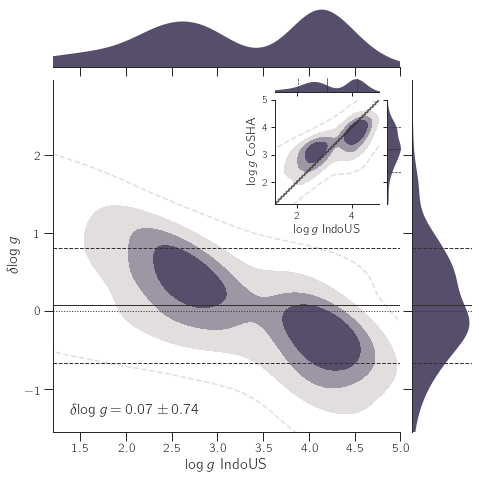

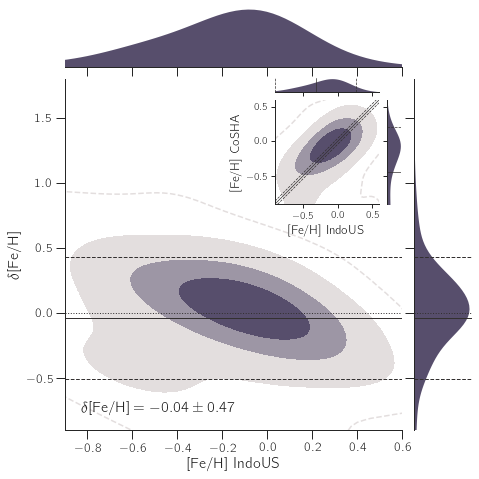

In [9]:
Y_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((3000,7200)), np.array((1.2,5.0)), np.array((-0.9,+0.6)), np.array((-0.2,+1.2))]
))
DELTA_LIMS = dict(zip(
    Y_COLUMNS,
    [np.array((-1200,+1500)), None, np.array([-0.9,1.2]), None]
))

compare_with = "IndoUS"
comparison = build_comparison_table(y_cosha_indous, y_indous, labela="CoSHA", labelb=compare_with, columns=list(cols.values()), delta_prefix=r"$\delta$")

for label, column in cols.items():
    if comparison[f"{column} {compare_with}"].isna().all(): continue
    d = delta_inset_plot(
            comparison_table=comparison,
            column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
            labelx=compare_with, labely="CoSHA", delta_prefix=r"$\delta$",
            limx=Y_LIMS[label], limy=DELTA_LIMS[label], guide_color="#333030"
        )
    d.fig.savefig(f"_img/{label.lower()}-residuals-inset-{compare_with.lower()}.png", bbox_inches="tight")